# Crypto Trading Environment

In this section we will set up the crypto data and the `gym` trading environment for our Reinforcement Learning agent.



## Installing dependencies

In [ ]:
from IPython.display import clear_output

# Set up Stable Baselines3
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

clear_output()

# Check if the custom environment is compatible with stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, DDPG

In [ ]:
# Install pandas technical analysis
!pip install pandas-ta

clear_output()

# Import pandas technical analysis
import pandas_ta as ta

In [ ]:
# Download TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

!tar xvzf ta-lib-0.4.0-src.tar.gz

import os
# Can't use !cd in co-lab
os.chdir('ta-lib') 

!./configure --prefix=/usr

!make

# wait ~ 30s
!make install

os.chdir('../')

!pip install TA-Lib

clear_output()

# Used for Technical analysis
import talib

In [ ]:
# Access Google Drive
from google.colab import drive

# Used to concat folders
import os

# Used for API Request
import requests

# Modify data
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn import preprocessing

# Used to check if two lines intersect (MACD)
from shapely.geometry import LineString

# Used to normalize the data
import scipy

# Display data
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Make the agent's environment
import gym

In [ ]:
drive.mount('/content/drive')
# Insert your Google drive path
path = ""

Mounted at /content/drive


## Which Crypto Currency will be used?

For this `gym` environment Bitcoin's USD price will be used. Bitcoin was the first crypto currency and was created in 2009. At the time of writing this, Bitcoin has the highest price and crypto market leader. The entire crypto market follow's Bitcoin's bearish and bullish trends.

We will use a slightly enhanced version of class `LiveBinanceData` from **1. Crypto Trading Metrics.ipynb**.

In [ ]:
class LiveBinanceData():
  """
  This library uses live data from Binance

  'params' consists of:

    - apiKey - the API key that binance needs
    
    - apiSecret - the API secret that binance needs
    
    - currency - the pair that will be traded eg. BTCUSDT
    
    - smtp - the smtp server

    - port - the port that is used for the server
    
    - email - the email that will send the message

    - password - the email's password

    - recipients - the people who will receive the email

  NOTE: apiKey and apiSecret are fetched from
  https://www.binance.com/en/my/settings/api-management
  """
  def __init__(self, params):    
    # Increase the data precision for the numbers
    pd.set_option("display.precision", 8)

    import os
    
    try:
      # Fetches crypto data
      import binance

    except ModuleNotFoundError:
      # Install binance
      os.system('pip install python-binance')
      # Fetches crypto data
      import binance

    finally:
      # Connect to API
      self.__client = binance.Client(params["apiKey"], params["apiSecret"])
      # Set the currency to be fetched
      self.__currency = params["currency"]
      
      # Email data
      self.__smtp = params["smtp"]
      self.__port = params["port"]
      self.__email = params["email"]
      self.__password = params["password"]
      self.__recipients = params["recipients"]

      print("                       _        ")
      print("                      | |       ")
      print("  ___ _ __ _   _ _ __ | |_ ___  ")
      print(" / __| '__| | | | '_ \\| __/ _ \\ ")
      print("| (__| |  | |_| | |_) | || (_) |")
      print(" \\___|_|   \\__, | .__/ \\__\\___/ ")
      print("            __/ | |             ")
      print("           |___/|_|             ")



  """
  Returns the live market data from 1 day candlesticks 
  since the start of Binance in a Pandas DataFrame.
  """
  def getDailyCandles(self):
    # Get earliest timestamp
    timestamp = self.__client._get_earliest_valid_timestamp(self.__currency, '1d')
    # Fetch data
    apiData = self.__client.get_historical_klines(self.__currency, self.__client.KLINE_INTERVAL_1DAY, timestamp)

    return self.__preprocess(apiData)



  """
  Returns the live market data in 1 hour candlesticks 
  since the start of Binance in a Pandas DataFrame.
  """
  def get1HourCandles(self):
    # Get earliest timestamp
    timestamp = self.__client._get_earliest_valid_timestamp(self.__currency, '1h')
    # Fetch data
    apiData = self.__client.get_historical_klines(self.__currency, self.__client.KLINE_INTERVAL_1HOUR, timestamp)

    return self.__preprocess(apiData)
    


  """
  Returns the live market data in 4 hour candlesticks 
  since the start of Binance in a Pandas DataFrame.
  """
  def get4HourCandles(self):
    # Get earliest timestamp
    timestamp = self.__client._get_earliest_valid_timestamp(self.__currency, '4h')
    # Fetch data
    apiData = self.__client.get_historical_klines(self.__currency, self.__client.KLINE_INTERVAL_4HOUR, timestamp)

    return self.__preprocess(apiData)



  """
  Return the market data for the past 24 hours
  """
  def get24Hours(self):
    # Fetch data
    apiData = self.__client.get_historical_klines(self.__currency, self.__client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")

    return self.__preprocess(apiData)



  """
  Return the wallet of the connected client
  """
  def getWallet(self):
    data = pd.DataFrame(self.__client.get_account()['balances'])
    # Convert strings to numbers
    frames = [data["asset"], data[["free", "locked"]].apply(pd.to_numeric, axis = 1)]
    # Weird Pandas needs to concat the data rather than edit it
    data = pd.concat(frames,  axis = 1)

    data = data.loc[data["free"] > 0]

    return data.copy()



  """
  Preprocesses the data:
    - Converts to Pandas DataFrame
    - Convert values in correct dtype
    - The 'Ignore' column has been removed.

  apiData - the data from the API call (non processed)
  """
  def __preprocess(self, apiData):
    columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", 
            "Close Time", "Quote Asset Volume", "Number of Trades", 
            "TB Asset Volume", "TB Quote Volume", "Ignore"]

    data = pd.DataFrame(apiData, columns = columns)
    data = data.drop(labels=["Ignore"], axis = 1)

    """
    The dates in Binance are returned as timestamps.
    They have to be divided by 1000 and then set to
    seconds to be correctly converted.
    """
    data['Open Time'] = pd.to_datetime(data['Open Time'] / 1000, unit = 's')
    data['Close Time'] = pd.to_datetime(data['Close Time'] / 1000, unit = 's')

    numCols = ["Open", "High", "Low", "Close", "Volume", 
           "Quote Asset Volume", "TB Asset Volume", 
           "TB Quote Volume"]

    data[numCols] = data[numCols].apply(pd.to_numeric, axis = 1)

    return data.copy()

In [ ]:
# Put your own API key and Secret - https://www.binance.com/en/my/settings/api-management
apiKey = ""
apiSecret = ""

# Set currency Bitcoin - GBP
currency = "BTCUSDT"

# For SSL - put your own gmail data
port = None  
smtp = ""
email = ""
password = ""
# Email list
recipients = []

params = {
    "apiKey": apiKey,
    "apiSecret": apiSecret,
    "currency": currency,
    "smtp": smtp,
    "port": port,
    "email": email,
    "password": password,
    "recipients": recipients
}

live = LiveBinanceData(params)

                       _        
                      | |       
  ___ _ __ _   _ _ __ | |_ ___  
 / __| '__| | | | '_ \| __/ _ \ 
| (__| |  | |_| | |_) | || (_) |
 \___|_|   \__, | .__/ \__\___/ 
            __/ | |             
           |___/|_|             


## Exploratory Data Analysis

We will explore the daily candle sticks in order to reduce the noise that metrics can produce in the hourly trades.


In [ ]:
dailyData = live.getDailyCandles()

### What time of the day are most of the trades executed?

Unlike FX and the stock market, the crypto market is open 24/7 which means that trades can be executed any times. Further investigation can be carried out to see when traders are most active during the day.

**Note**: The timezone of the dataset is Greenwich Mean Time (GMT).

In [ ]:
# Extract the hour of the datetime64
def getHour(date):
  return date.hour

In [ ]:
dataOneHour = live.get1HourCandles()

firstDate = str(dataOneHour["Open Time"].min()).split(" ")[0]
lastDate = str(dataOneHour["Open Time"].max()).split(" ")[0]

temp = pd.DataFrame()
temp["Hour"] = dataOneHour["Open Time"].apply(getHour)
temp["Trades"] = dataOneHour["Number of Trades"]
temp["Volume"] = dataOneHour["Volume"]

# Sum the number of trades for every hour (0 - 23)
temp = temp.groupby("Hour").sum().reset_index()

fig = px.bar(temp, x="Hour", y="Trades", title = f"{currency} transactions and volume grouped by hour of day from {firstDate} to {lastDate}", color='Volume', text_auto = "Volume")
fig.update_traces(textposition='outside')
fig.show()

### Which trading metrics can be given to the agent?

The most used metrics in Reinforcement Learning Trading research are:

- Moving Average Convergence Divergence (MACD)

- Relative Strength Index  (RSI)

- Commodity Channel Index (CCI)

- Average Directional Index (ADX)

These metrics will be further explored in order to decide if they will be useful to the agent.



#### Moving Average Convergence Divergence (MACD)

Moving averages are trading indicators that aim to ‘smooth out’ price fluctuations in order to help separate trends from general market activity. MACD follows the momentum between two moving averages of a price. The primary signals for MACD are:

1. **MACD** - the value of an exponential moving average (EMA) subtracted from another EMA with a shorter lookback period. Common values are 26 days for the longer EMA and 12 for the shorter. This is referred to as the ‘slow’ signal line of the MACD.

2. **Signal** - the EMA of the MACD of a period shorter than the shortest period used in calculating the MACD. Typically, a 9-day period is used. This is referred to as the ‘fast’ signal line.

3. **Difference** – the difference between the MACD – Trigger line is used to represent current selling pressures in the marketplace. This value is commonly charted as a histogram overlaying the MACD + Trigger signals. **A positive value for this signal represents a bullish trend whereas a negative value indicates a bearish one.**



In [ ]:
# Usual set ups are fast = 26, slow = 12, signal = 9
def macd(df, fast = 26, slow = 12, signal = 9):
  temp = df.copy()

  # MACD
  temp["MACD"] = temp.ta.macd(fast, slow, signal)["MACD_12_26_9"]
  # Signal
  temp["MACD S"] = temp.ta.macd(fast, slow, signal)["MACDs_12_26_9"]
  # Histogram
  temp["MACD H"] = temp.ta.macd(fast, slow, signal)["MACDh_12_26_9"]

  return temp.copy()

In [ ]:
dailyData = macd(dailyData)

fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = (f'{currency} history', 'MACD'))

# Candlestick
fig.add_trace(go.Candlestick(x = dailyData['Open Time'],
                             open = dailyData['Open'],
                             high = dailyData['High'],
                             low = dailyData['Low'],
                             close = dailyData['Close'],
                             name = 'Candle'),
              row = 1, col = 1)
# MACD
fig.append_trace(go.Scatter(x = dailyData["Close Time"], y = dailyData["MACD"], 
                            line=dict(color='#0000FF', width=2),
                            name = "MACD"),
                 row = 2, col = 1)

# MACD Signal
fig.append_trace(go.Scatter(x = dailyData["Close Time"], y = dailyData["MACD S"], 
                            line=dict(color='#FF0000', width=2),
                            name = "Signal"),
                 row = 2, col = 1)

# Add colours to histogram
colors = np.where(dailyData['MACD H'] < 0, '#ff0000', '#00FF00')

# MACD Histogram
fig.append_trace(go.Bar(x = dailyData["Close Time"], y = dailyData["MACD H"],
                        name = "Histogram", marker_color = colors),
                 row = 2, col = 1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(hovermode = "x unified")

/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:2312: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




##### MACD Line crossing

When there is a crossover between the **Signal** and **MACD** lines that means the **market is trending**. However when the **MACD line crosses above the Signal line** this is a **buy indicator** and when the **MACD line crosses below the Signal line** this is a **sell indicator**.

In [ ]:
# Check if two lines intersect or not
def isIntersect(macds, signals, indexes):
  lineM = LineString(np.column_stack((indexes, macds)))
  lineS = LineString(np.column_stack((indexes, signals)))
  intersection = lineM.intersection(lineS)
  
  # NOTE: is_empty returns True when there is not intersection
  return not intersection.is_empty

In [ ]:
# Demo function to showcase how lines cross
def plotPrices(macds, signals, indexes):
  title = "MACD x Signal"

  intersection = isIntersect(macds, signals, indexes)
  
  # If the two lines cross and MACD for the next day is bigger than that Signal => Bullish
  if macds[1] > signals[1] and intersection:
    title = title + " - Buy"
   # If the two lines cross and MACD for the next day is lesser than that Signal => Bearish
  elif macds[1] < signals[1] and intersection:
    title = title + " - Sell"
  
  plt.title(title)
  plt.plot(indexes, macds, label = "MACD")
  plt.plot(indexes, signals, label = "Signal")

  # Show the intersection of MACD and Signal
  lineM = LineString(np.column_stack((indexes, macds)))
  lineS = LineString(np.column_stack((indexes, signals)))
  intersection = lineM.intersection(lineS)
  plt.plot(*intersection.xy, 'ro')
  plt.grid()
  plt.legend(loc = "upper right")
  
  plt.show()

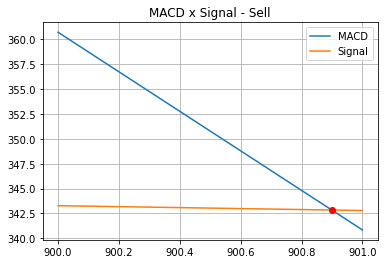

In [ ]:
# MACD x Signal - Bearish market
index = dailyData[dailyData["Open Time"] == "2020-02-03"].index[0]

# MACD -  moves faster and is more sensitive to changes
macds = [dailyData.iloc[index]['MACD'], dailyData.iloc[index + 1]['MACD']]

# MACD Signal - reacts slower to price changes
signals = [dailyData.iloc[index]['MACD S'], dailyData.iloc[index + 1]['MACD S']]
indexes = [index, index + 1]

plotPrices(macds, signals, indexes)

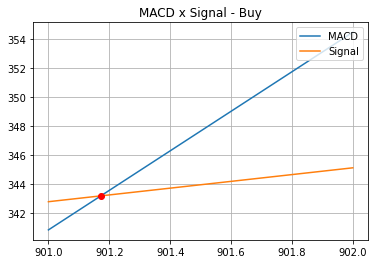

In [ ]:
# MACD x Signal - Bullish market
index = dailyData[dailyData["Open Time"] == "2020-02-04"].index[0]

# MACD -  moves faster and is more sensitive to changes
macds = [dailyData.iloc[index]['MACD'], dailyData.iloc[index + 1]['MACD']]

# MACD Signal - reacts slower to price changes
signals = [dailyData.iloc[index]['MACD S'], dailyData.iloc[index + 1]['MACD S']]
indexes = [index, index + 1]

plotPrices(macds, signals, indexes)

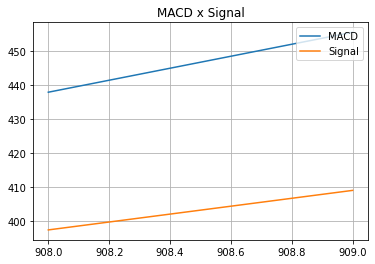

In [ ]:
# Not crossed
index = dailyData[dailyData["Open Time"] == "2020-02-11"].index[0]

# MACD -  moves faster and is more sensitive to changes
macds = [dailyData.iloc[index]['MACD'], dailyData.iloc[index + 1]['MACD']]

# MACD Signal - reacts slower to price changes
signals = [dailyData.iloc[index]['MACD S'], dailyData.iloc[index + 1]['MACD S']]
indexes = [index, index + 1]

plotPrices(macds, signals, indexes)

In order to correctly identify when the points cross and if it is a bullish or bearish signal we will have to loop over the results and update the row. We will have to check the **MACD** and **Signal** for 2 consecutive days to see where the lines cross.

In [ ]:
def macdStatus(df):
  data = df.copy()
  # Define column for "Bullish" and "Bearish" signals
  data["MACD Status"] = "None"

  # Iterate over the dataset to update "MACD Status"
  for index in range(len(data)):
    # Check if next value is the last one
    if index + 1 < len(data):

      # MACD for current and next index
      macds = [data.iloc[index]['MACD'], data.iloc[index + 1]['MACD']]

      # MACD Signal - reacts slower to price changes
      signals = [data.iloc[index]['MACD S'], data.iloc[index + 1]['MACD S']]
      # X axis
      indexes = [index, index + 1]

      # Check if the current lines cross
      intersection = isIntersect(macds, signals, indexes)
    
      # If the two lines cross and MACD for the next day is bigger than that Signal => Bullish
      if macds[1] > signals[1] and intersection:
        data.at[index + 1, 'MACD Status'] = "Buy"
      # If the two lines cross and MACD for the next day is lesser than that Signal => Bearish
      elif macds[1] < signals[1] and intersection:
        data.at[index + 1, 'MACD Status'] = "Sell"
  return data.copy()

In [ ]:
dailyData = macdStatus(dailyData)
print(f"MACD Statuses:\t{dailyData['MACD Status'].unique()}")

MACD Statuses:	['None' 'Buy' 'Sell']


#### Relative Strength Index (RSI)

An effective trading strategy would be to see which way the trend is pointing - is it going up or is it going down. RSI is a momentum indicator that describes the current price relative to average high and low prices over a previous trading period. This indicator estimates overbought or oversold status and helps spot trend reversals, price pullbacks, and the emergence of bullish or bearish markets.

**Traditionally the RSI is considered overbought when above 70 and oversold when below 30.**

In [ ]:
def rsi(df, periods = 14, ema = True):
  """
  Returns a pd.Series with the relative strength index.
  """
  close_delta = df['Close'].diff()

  # Make two series: one for lower closes and one for higher closes
  up = close_delta.clip(lower=0)
  down = -1 * close_delta.clip(upper=0)

  if ema == True:
    # Use exponential moving average
      ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
      ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
  else:
      # Use simple moving average
      ma_up = up.rolling(window = periods, adjust=False).mean()
      ma_down = down.rolling(window = periods, adjust=False).mean()
      
  rsi = ma_up / ma_down
  rsi = 100 - (100/(1 + rsi))

  return rsi.round(decimals=2)

In [ ]:
dailyData["RSI"] = rsi(dailyData)

fig = make_subplots(rows=2, cols=1, subplot_titles=(f"{currency} price", "RSI"))

fig.add_trace(go.Candlestick(x = dailyData['Open Time'],
                             open = dailyData['Open'],
                             high = dailyData['High'],
                             low = dailyData['Low'],
                             close = dailyData['Close'],
                             name = 'Candle'), row=1, col=1)

fig.add_trace(go.Scatter(x = dailyData["Open Time"], y = dailyData["RSI"], mode='lines', line_color='#187BCD', name = "RSI"),
    row=2, col=1)

fig.add_hline(y=30, col=1, row=2, line_color="#00FF00", line_width=2, line_dash="dot")
fig.add_hline(y=70, col=1, row=2, line_color="#FF0000", line_width=2, line_dash="dot")

fig.update(layout_xaxis_rangeslider_visible=False)

#### Average Directional Index (ADX)

ADX is used to determine the strength of a trend. The trend can be either up (positive directional indicator +DI) or down (negative directional indicator -DI). This metric consists of three different lines which are used to further support if a trade taken at all or if the trade should be taken short or long.

The trend has strength when ADX is above 25 and the trend is weak / prices are trendless when ADX is below 20. Non-trending can also mean that the price is making a trend change or is currently too volatile for a clear direction.

**When +DI rises above -DI this means that it is time to buy, whereas when -DI rises above +DI this indicates that it is time to sell.**

**ADX Value** | **Trend Strength**
--- | ---
0-25 | Weak trend
25 - 50 | Strong trend
50 - 75 | Very strong trend
75 - 100 | Extremely strong trend


In [ ]:
def adx(df, lookback = 14):
  temp = df.copy()
  high = temp['High'].copy()
  low = temp['Low'].copy()
  close = temp['Close'].copy()

  plusDm = high.diff()
  minusDm = low.diff()
  plusDm[plusDm < 0] = 0
  minusDm[minusDm > 0] = 0

  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift(1)))
  tr3 = pd.DataFrame(abs(low - close.shift(1)))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
  atr = tr.rolling(lookback).mean()

  temp["+DMI"] = 100 * (plusDm.ewm(alpha = 1/lookback).mean() / atr)
  temp["-DMI"] = abs(100 * (minusDm.ewm(alpha = 1/lookback).mean() / atr))
  dx = (abs(temp["+DMI"] - temp["-DMI"]) / abs(temp["+DMI"] + temp["-DMI"])) * 100
  temp["ADX"] = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
  adx_smooth = temp["ADX"].ewm(alpha = 1/lookback).mean()

  return temp.copy()

In [ ]:
dailyData = adx(dailyData)

fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = (f"{currency} price", "Average Directional Index "))

# Candlestick
fig.add_trace(go.Candlestick(x = dailyData['Open Time'],
                             open = dailyData['Open'],
                             high = dailyData['High'],
                             low = dailyData['Low'],
                             close = dailyData['Close'],
                             name = 'Candle'),
              row = 1, col = 1)

# +DMI
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData["+DMI"], 
                         line_color = 'green', name = '+DMI'), 
              row = 2, col = 1)

# ADX
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData['ADX'],
                         line_color = 'black', name = 'ADX'),
              row = 2, col = 1)

# Lower Bollinger Band
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData["-DMI"],
                         line_color = 'red', name = '-DMI'),
              row = 2, col = 1)


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(hovermode = "x unified")

#### Commodity Channel Index (CCI)

This is a lagging momentum oscillator that signals overbought and oversold levels by measuring the difference between current and historical prices. This metric does not have set limits (like RSI). **Usually the conditions are identified when the line(s) are outside a range of +100 (overbought) or -100 (oversold).**



In [ ]:
dailyData['CCI'] = talib.CCI(dailyData['High'], dailyData['Low'], dailyData['Close'])

fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = ('History', 'Commodity Channel Index'))

# Candlestick
fig.add_trace(go.Candlestick(x = dailyData['Open Time'],
                             open = dailyData['Open'],
                             high = dailyData['High'],
                             low = dailyData['Low'],
                             close = dailyData['Close'],
                             name = 'Candle'),
              row = 1, col = 1)

# CCI 
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData["CCI"], 
                         line_color = 'orange', name = 'CCI'), 
              row = 2, col = 1)

# +100 line
fig.add_hline(y=100, col=1, row=2, line_color="#000000", line_width=2, line_dash="dot")
# -100 line
fig.add_hline(y=-100, col=1, row=2, line_color="#000000", line_width=2, line_dash="dot")


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(hovermode = "x unified")

### How to track volatility?

Volatility is a variation of a trading price series over time. Cryptocurrencies are popular for being very volatile. Volatility is a category of indicators that are used to measure how volatile the price is in a specific period of time.




#### Double Bollinger Bands

Bollinger Bands are used as overbought and oversold indicators but given the trending nature of crypto, there are more efficient ways to use the bands. Bollinger Bands consist of three lines - the 20-period moving average and two standard deviations. One of the STDs is above and the other is below the moving average.

The Bollinger Band Squeeze occurs when volatility falls to low levels and the Bollinger Bands narrow. According to John Bollinger, periods of low volatility are often followed by periods of high volatility. Therefore, a volatility contraction or narrowing of the bands can foreshadow a significant advance or decline.

In [ ]:
def doubleBollingerBands(df, period = 20):
  temp = df.copy()

  # Simple Moving Average
  temp['SMA'] = temp["Close"].rolling(period).mean()

  # Standard Deviation
  std = temp["Close"].rolling(period).std(ddof = 0)
  # Upper Bollinger Band
  temp['Upper Band'] = temp['SMA'] + (std * 2)
  # Lower Bollinger Band
  temp['Lower Band'] = temp['SMA'] - (std * 2)

  del std

  return temp

In [ ]:
dailyData = doubleBollingerBands(dailyData)

fig = go.Figure(data=[go.Candlestick(x = dailyData['Open Time'],
                open = dailyData['Open'],
                high = dailyData['High'],
                low = dailyData['Low'],
                close = dailyData['Close'],
                name = 'Candle')] )

# Upper Bollinger Band
fig.add_trace(go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['Upper Band'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'Upper Band'))

fig.add_trace(go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['SMA'],
                         line_color = 'black',
                         name = 'Simple Moving Average'))

# Lower Bollinger Band
fig.add_trace(go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['Lower Band'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'Lower Band'))

fig.update_layout(hovermode = "x unified", title_text = f"{currency} Double Bollinger Bands")
fig.show()

#### Average True Range (ATR)

ATR can tell how volatile an asset has been on average over a specified period. This metric is useful for setting exit levels as part of a risk management strategy. It also tells how strong price movements are in order to identify a trend.

**True Range** is a way of measuring an asset's daily trading range that accounts for gap openings and gives a sense of how much the asset's price has actually moved over time.

In [ ]:
dailyData['ATR'] = talib.ATR(dailyData['High'], dailyData['Low'], dailyData['Close'])

fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = (f"{currency} price", "Average True Rating"))

# Candlestick
fig.add_trace(go.Candlestick(x = dailyData['Open Time'],
                             open = dailyData['Open'],
                             high = dailyData['High'],
                             low = dailyData['Low'],
                             close = dailyData['Close'],
                             name = 'Candle'),
              row = 1, col = 1)

# +DMI
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData["ATR"], 
                         line_color = '#187BCD', name = 'ATR'), 
              row = 2, col = 1)


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(hovermode = "x unified")

## Data Preprocessing

The agent will trade on the 1 hour candle sticks. They offer flexibility in term what the agent can do and the agent is given enough time to analyse trading opportunities. The 1 hour candle sticks also give more chances to trade in order to maximize profits.

The daily charts will be used to generate signals if it is a good or bad day to trade whereas the actual trading will occur on an hourly chart for the days in order for the agent to learn to trade.

In [ ]:
dailyData = live.getDailyCandles()

hourlyData = live.get1HourCandles()

### Which timeframe will be used?

It is a common practice by traders to use different candlestick timeframes in order to make the best trading decision. We will use the daily and 1 hour candlestick charts. The **daily** chart will be used in order to **determine the market's trend, bearish or bullish**, and the **hourly** chart will be used to **determine the price's volatility and will be given to the agent to make a buy / sell / hold decision.**

The agent's data will be stored in `hourlyData`.

#### Daily candlesticks

The daily chart will give us an insight on the daily market trend. We will use 3 different metrics to determine the market's trend - **MACD**, **ADX** and **Ichimoku Cloud**.



##### Ichimoku Kino Hyo

Reinforcement Learning researchers have not used **Ichimoku Kino Hyo** (Ichimoku Cloud) but it combines the market's momentum, trend, support and resistance into one indicator. The five lines of Ichimoku combine to form a cloud which collapses the information from all five linesi into an easier to read formation.

- **Tenkan-Sen (Baseline)** - is the moving average (red line) and represents. the trend (upwards, downwards or sideways).

- **Kijun-Sen (Conversion line)** - acts as support and resistance (blue line). It is similar to Tenkan-Sen (Baseline) but has a longer timeframe. This line usually lags the Tenkan-Sen (Baseline).

- **Senkou A (Leading Span A)** - is the average of highs and lows of the latter two lines (orange line).

- **Senkou B (Leading Span B)** - is an expanded version of **Senkou A (Leading Span A)**. If Senkou A (Leading Span A) is above Senkou B (Leading Span B) then the "cloud" is green and if Senkou A (Leading Span A) is below Senkou B (Leading Span B) the "cloud" is red.

- **Chikou Span (Lagging Span)** - shifts the current price 26 periods leftward (grene line).

In [ ]:
def ichimokuKinoHyo(df):
  ichimoku = df.copy()

  # Tenkan-Sen (Baseline)
  period9High = ichimoku['High'].rolling(window = 9).max()
  period9Low = ichimoku['Low'].rolling(window = 9).min()

  ichimoku['Tenkan-Sen'] = (period9High + period9Low) / 2

  # Kijun-Sen (Conversion line)
  period26High = ichimoku['High'].rolling(window = 26).max()
  period26Low = ichimoku['Low'].rolling(window = 26).min()

  ichimoku['Kijun-Sen'] = (period26High + period26Low) / 2

  # Senkou Span A (Leading Span A)
  ichimoku['Senkou A'] = ((ichimoku['Tenkan-Sen'] + ichimoku['Kijun-Sen']) / 2).shift(26)

  # Senkou Span B (Leading Span B)
  period52High = ichimoku['High'].rolling(window = 52).max()
  period52Low = ichimoku['Low'].rolling(window = 52).min()

  ichimoku['Senkou B'] = ((period52High + period52Low) / 2).shift(26)

  # Chikou Span (Lagging span)
  ichimoku['Chikou Span'] = ichimoku['Close'].shift(-26)

  return ichimoku.copy()

In [ ]:
dailyData = ichimokuKinoHyo(dailyData)

fig = go.Figure(data = [go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['Tenkan-Sen'],
                         line_color = 'red',
                         name = 'Tenkan-Sen')])

fig.add_trace(go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['Kijun-Sen'],
                         line_color = 'blue',
                         name = 'Kijun-Sen'))

fig.add_trace(go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['Senkou A'],
                         line_color = 'orange',
                         name = 'Senkou A'))

fig.add_trace(go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['Senkou B'],
                         line_color = 'black',
                         name = 'Senkou B'))

fig.add_trace(go.Scatter(x = dailyData['Open Time'],
                         y = dailyData['Chikou Span'],
                         line_color = 'green',
                         name = 'Chikou Span'))

fig.update_layout(hovermode = "x unified", title_text = f"Ichimoku Kino Hyu for {currency}")
fig.show()

###### Signals

**Buy**
- Prices rise above the cloud
- Cloud turns from red to green
- Price moves above Kijun-Sen (Conversion line)
- Tenkan-Sen (Baseline) rises above Kijun-Sen (Conversion line)

**Sell**
- Prices fall below the cloud
- Cloud turns from green to red
- Prices moves below Kijun-Sen (Conversion line)
- Tenkan-Sen (Baseline) falls below Kijun-Sen (Conversion line)


In [ ]:
# Generate buy and sell signals
def getIchimokuSignals(df):

  temp = df.copy()

  temp['Ichimoku Signal'] = "None"

  # Generate Buy signals

  # Prices are above the cloud
  temp.loc[np.logical_and(temp['Close'] > temp['Senkou A'], temp['Close'] > temp['Senkou B']), 'Ichimoku Signal'] = "Buy"

  # Green clouds
  temp.loc[temp['Senkou A'] > temp['Senkou B'], 'Ichimoku Signal'] = "Buy"

  # Price moves above Kijun-Sen (Conversion line)
  temp.loc[temp['Close'] > temp['Kijun-Sen'], 'Ichimoku Signal'] = "Buy"

  # Tenkan-Sen (Baseline) rises above Kijun-Sen (Conversion line)
  temp.loc[temp['Tenkan-Sen'] > temp['Kijun-Sen'], 'Ichimoku Signal'] = "Buy"

  # -----------------------------------------------------------------------------------------------------------------------------

  # Generate Sell signals

  # Prices are below the cloud
  temp.loc[np.logical_and(temp['Close'] < temp['Senkou A'], temp['Close'] < temp['Senkou B']), 'Ichimoku Signal'] = "Sell"

  # Red clouds
  temp.loc[temp['Senkou A'] < temp['Senkou B'], 'Ichimoku Signal'] = "Sell"

  # Price moves below Kijun-Sen (Conversion line)
  temp.loc[temp['Close'] < temp['Kijun-Sen'], 'Ichimoku Signal'] = "Sell"

  # Tenkan-Sen (Baseline) falls below Kijun-Sen (Conversion line)
  temp.loc[temp['Tenkan-Sen'] < temp['Kijun-Sen'], 'Ichimoku Signal'] = "Sell"

  return temp['Ichimoku Signal']

In [ ]:
dailyData['Ichimoku Signal'] = getIchimokuSignals(dailyData)

Even though the Ichimoku Signals are generated, they need to be checked if there are still any remaining `None`. If there are remaining `None` signals they will have to be changed from `None` to either `Buy` or `Sell` depending on what was the previous signal.

In [ ]:
print(f"There are {len(dailyData.loc[dailyData['Ichimoku Signal'].str.contains('None')])} 'None' Ichimoku Signals.\n\n")

dailyData.loc[dailyData['Ichimoku Signal'].str.contains('None')]

There are 25 'None' Ichimoku Signals.




,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Asset Volume,TB Quote Volume,Tenkan-Sen,Kijun-Sen,Senkou A,Senkou B,Chikou Span,Ichimoku Signal
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.45477005e+06,3427,616.248541,2.67821640e+06,NaN,NaN,NaN,NaN,4163.72,None
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.08695831e+06,5233,972.868710,4.12912332e+06,NaN,NaN,NaN,NaN,3944.69,None
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.54948374e+06,2153,274.336042,1.11800187e+06,NaN,NaN,NaN,NaN,3189.02,None
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.93036439e+06,2321,376.795947,1.55740133e+06,NaN,NaN,NaN,NaN,3700.00,None
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.79723171e+06,3972,557.356107,2.25566255e+06,NaN,NaN,NaN,NaN,3714.95,None
5,2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858,2017-08-22 23:59:59.999000064,3.75250577e+06,6494,423.995181,1.63718837e+06,NaN,NaN,NaN,NaN,3699.99,None
6,2017-08-23,4040.00,4265.80,4013.89,4114.01,1001.136565,2017-08-23 23:59:59.999000064,4.14868647e+06,8629,309.419092,1.29356710e+06,NaN,NaN,NaN,NaN,4035.01,None
7,2017-08-24,4147.00,4371.68,4085.01,4316.01,787.418753,2017-08-24 23:59:59.999000064,3.29647641e+06,6247,206.820412,8.68379064e+05,NaN,NaN,NaN,NaN,3910.04,None
8,2017-08-25,4316.01,4453.91,4247.48,4280.68,573.612740,2017-08-25 23:59:59.999000064,2.48463735e+06,6554,100.097974,4.34577136e+05,3942.695,NaN,NaN,NaN,3900.00,None
9,2017-08-26,4280.71,4367.00,4212.41,4337.44,228.108068,2017-08-26 23:59:59.999000064,9.77865733e+05,2260,56.190141,2.41363801e+05,3926.955,NaN,NaN,NaN,3609.99,None


The `None` signals are at the beginning of the dataset whilst Ichimoku Kino Hyu was being generated. They are due to the `NaN` values in columns `Tenkan-Sen`, `Kijun-Sen`, `Senkou A` and `Senkou B`. The `NaN` values will be dealt with in the **Missing Values** section.

##### Moving Average Convergence Divergence (MACD)

The MACD code from **Exploratory Data Analysis** will be reused to generate the necessary signals. Further explanation can be found in the **Exploratory Data Analysis** section.

In [ ]:
# Usual set ups are fast = 26, slow = 12, signal = 9
def macd(df, fast = 26, slow = 12, signal = 9):
  temp = df.copy()

  # MACD
  temp["MACD"] = temp.ta.macd(fast, slow, signal)["MACD_12_26_9"]
  # Signal
  temp["MACD S"] = temp.ta.macd(fast, slow, signal)["MACDs_12_26_9"]
  # Histogram
  temp["MACD H"] = temp.ta.macd(fast, slow, signal)["MACDh_12_26_9"]

  return temp.copy()

In [ ]:
dailyData = macd(dailyData)

fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = (f'{currency} history', 'MACD'))

# Candlestick
fig.add_trace(go.Candlestick(x = dailyData['Open Time'],
                             open = dailyData['Open'],
                             high = dailyData['High'],
                             low = dailyData['Low'],
                             close = dailyData['Close'],
                             name = 'Candle'),
              row = 1, col = 1)
# MACD
fig.append_trace(go.Scatter(x = dailyData["Close Time"], y = dailyData["MACD"], 
                            line=dict(color='#0000FF', width=2),
                            name = "MACD"),
                 row = 2, col = 1)

# MACD Signal
fig.append_trace(go.Scatter(x = dailyData["Close Time"], y = dailyData["MACD S"], 
                            line=dict(color='#FF0000', width=2),
                            name = "Signal"),
                 row = 2, col = 1)

# Add colours to histogram
colors = np.where(dailyData['MACD H'] < 0, '#ff0000', '#00FF00')

# MACD Histogram
fig.append_trace(go.Bar(x = dailyData["Close Time"], y = dailyData["MACD H"],
                        name = "Histogram", marker_color = colors),
                 row = 2, col = 1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(hovermode = "x unified")

/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:2312: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [ ]:
# Check if two lines intersect or not
def isIntersect(macds, signals, indexes):
  lineM = LineString(np.column_stack((indexes, macds)))
  lineS = LineString(np.column_stack((indexes, signals)))
  intersection = lineM.intersection(lineS)
  
  # NOTE: is_empty returns True when there is not intersection
  return not intersection.is_empty

Now that the `Buy`, `Sell` and `None` signals can be generated with the latter used `macdStatus` function, the incorrect `None` signals need to be fixed. 

An incorrect `None` signal is a `None` signal which is between `Buy` and `Sell` or the other way around. They will have to be changed either to `Buy` or `Sell` depending on the initial trend trigger.

In [ ]:
# Change the None statuses to either Buy or Sell (from the first Buy or Sell occurrence onwards)
def statusFix(series):
  signals = series.copy()
  change = False
  # Store the first buy or sell signal
  newSignal = ""

  for i in range(len(signals)):
    # Check if current signal is different than None
    if signals[i] != "None":
      # Get the signal
      newSignal = signals[i]
      # Start changing the upcoming signals - from this point the signals should be either buy or sell
      change = True

    if change:
      # Change the signal on the previously encountered one (either buy or sell)
      signals[i] = newSignal
  
  return signals

In [ ]:
def macdStatus(df):
  data = df.copy()
  # Define column for "Bullish" and "Bearish" signals
  data["MACD Signal"] = "None"

  # Iterate over the dataset to update "MACD Status"
  for index in range(len(data)):
    # Check if next value is the last one
    if index + 1 < len(data):

      # MACD for current and next index
      macds = [data.iloc[index]['MACD'], data.iloc[index + 1]['MACD']]

      # MACD Signal - reacts slower to price changes
      signals = [data.iloc[index]['MACD S'], data.iloc[index + 1]['MACD S']]
      # X axis
      indexes = [index, index + 1]

      # Check if the current lines cross
      intersection = isIntersect(macds, signals, indexes)
    
      # If the two lines cross and MACD for the next day is bigger than that Signal => Bullish
      if macds[1] > signals[1] and intersection:
        data.at[index + 1, 'MACD Signal'] = "Buy"
      # If the two lines cross and MACD for the next day is lesser than that Signal => Bearish
      elif macds[1] < signals[1] and intersection:
        data.at[index + 1, 'MACD Signal'] = "Sell"
      
    # Fix MACD Signals
    data['MACD Signal'] = statusFix(data['MACD Signal'])

  return data.copy()

In [ ]:
dailyData = macdStatus(dailyData)
dailyData.loc[dailyData['MACD Signal'].str.contains('None')]

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Asset Volume,...,Tenkan-Sen,Kijun-Sen,Senkou A,Senkou B,Chikou Span,Ichimoku Signal,MACD,MACD S,MACD H,MACD Signal
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.45477005e+06,3427,616.248541,...,NaN,NaN,NaN,NaN,4163.72,None,NaN,NaN,NaN,None
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.08695831e+06,5233,972.868710,...,NaN,NaN,NaN,NaN,3944.69,None,NaN,NaN,NaN,None
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.54948374e+06,2153,274.336042,...,NaN,NaN,NaN,NaN,3189.02,None,NaN,NaN,NaN,None
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.93036439e+06,2321,376.795947,...,NaN,NaN,NaN,NaN,3700.00,None,NaN,NaN,NaN,None
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.79723171e+06,3972,557.356107,...,NaN,NaN,NaN,NaN,3714.95,None,NaN,NaN,NaN,None
5,2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858,2017-08-22 23:59:59.999000064,3.75250577e+06,6494,423.995181,...,NaN,NaN,NaN,NaN,3699.99,None,NaN,NaN,NaN,None
6,2017-08-23,4040.00,4265.80,4013.89,4114.01,1001.136565,2017-08-23 23:59:59.999000064,4.14868647e+06,8629,309.419092,...,NaN,NaN,NaN,NaN,4035.01,None,NaN,NaN,NaN,None
7,2017-08-24,4147.00,4371.68,4085.01,4316.01,787.418753,2017-08-24 23:59:59.999000064,3.29647641e+06,6247,206.820412,...,NaN,NaN,NaN,NaN,3910.04,None,NaN,NaN,NaN,None
8,2017-08-25,4316.01,4453.91,4247.48,4280.68,573.612740,2017-08-25 23:59:59.999000064,2.48463735e+06,6554,100.097974,...,3942.695,NaN,NaN,NaN,3900.00,None,NaN,NaN,NaN,None
9,2017-08-26,4280.71,4367.00,4212.41,4337.44,228.108068,2017-08-26 23:59:59.999000064,9.77865733e+05,2260,56.190141,...,3926.955,NaN,NaN,NaN,3609.99,None,NaN,NaN,NaN,None


Now the only `None` signals are at the beginning of the dataset while MACD and the Signal line are generated and untilt their initial crossing.

##### Average Directional Index (ADX)

The ADX code from **Exploratory Data Analysis** will be reused to generate the necessary signals. Further explanation can be found in the **Exploratory Data Analysis** section.

In [ ]:
def adx(df, lookback = 14):
  temp = df.copy()
  high = temp['High'].copy()
  low = temp['Low'].copy()
  close = temp['Close'].copy()

  plusDm = high.diff()
  minusDm = low.diff()
  plusDm[plusDm < 0] = 0
  minusDm[minusDm > 0] = 0

  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift(1)))
  tr3 = pd.DataFrame(abs(low - close.shift(1)))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
  atr = tr.rolling(lookback).mean()

  temp["+DMI"] = 100 * (plusDm.ewm(alpha = 1/lookback).mean() / atr)
  temp["-DMI"] = abs(100 * (minusDm.ewm(alpha = 1/lookback).mean() / atr))
  dx = (abs(temp["+DMI"] - temp["-DMI"]) / abs(temp["+DMI"] + temp["-DMI"])) * 100
  temp["ADX"] = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
  adx_smooth = temp["ADX"].ewm(alpha = 1/lookback).mean()

  temp["ADX Signal"] = "None"

  # When +DMI rises above -DMI this means that it is time to buy
  temp.loc[temp['+DMI'] > temp['-DMI'], "ADX Signal"] = "Buy"

  # When -DMI rises above +DMI this indicates that it is time to sell.
  temp.loc[temp['+DMI'] < temp['-DMI'], "ADX Signal"] = "Sell"

  return temp.copy()


In [ ]:
dailyData = adx(dailyData)

fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = (f"{currency} price", "Average Directional Index "))

# Candlestick
fig.add_trace(go.Candlestick(x = dailyData['Open Time'],
                             open = dailyData['Open'],
                             high = dailyData['High'],
                             low = dailyData['Low'],
                             close = dailyData['Close'],
                             name = 'Candle'),
              row = 1, col = 1)

# +DMI
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData["+DMI"], 
                         line_color = 'green', name = '+DMI'), 
              row = 2, col = 1)

# ADX
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData['ADX'],
                         line_color = 'black', name = 'ADX'),
              row = 2, col = 1)

# Lower Bollinger Band
fig.add_trace(go.Scatter(x = dailyData['Open Time'], y = dailyData["-DMI"],
                         line_color = 'red', name = '-DMI'),
              row = 2, col = 1)


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(hovermode = "x unified")

##### Fear and Greed Index

The Fear & Greed Index is a way to gauge stock market movements and whether stocks are fairly priced. The theory is based on the logic that excessive fear tends to drive down share prices, and too much greed tends to have the opposite effect.

The Fear & Greed Index is a compilation of seven different indicators that measure some aspect of stock market behaviour. They are market momentum, stock price strength, stock price breadth, put and call options, junk bond demand, market volatility, and safe haven demand. The index tracks how much these individual indicators deviate from their averages compared to how much they normally diverge. 

The index gives each indicator equal weighting in calculating a score from 0 to 100, with 100 representing maximum greediness and 0 signalling maximum fear.


In [ ]:
class FearAndGreedIndex():

  def __init__(self):
    # API url for current Fear and Greed Index
    self.urlCurrent = "https://api.alternative.me/fng/"
    # API url for Fear and Greed Index history
    self.urlHistory = "https://api.alternative.me/fng/?limit=0"

  # Fetches live API data
  def __getLiveData(self, url):
    # Make REST GET call and convert the data to JSON
    data = requests.get(url).json()
    # Test if there are any errors from the server side
    assert data['metadata']['error'] == None, f"Error from REST call: {data['metadata']['error']}"

    return data

  # Return an integer number of the fear and greed index
  def getValue(self):
    data = self.__getLiveData(self.urlCurrent)
    return int(data['data'][0]['value'])

  # Return the date of the Fear and Greed index from REST call
  def getDate(self):
    # Fetch API data
    data = self.__getLiveData(self.urlCurrent)
    return datetime.fromtimestamp(int(data['data'][0]['timestamp'])).strftime('%d-%m-%Y')

  # Return the history of the Fear and Greed Index
  def getHistory(self):
    # Fetch API data
    data = self.__getLiveData(self.urlHistory)
    # Convert to Pandas DataFrame
    data = pd.DataFrame(data["data"])

    # Data processing

    # Remove update stamp
    data = data.drop(labels=["time_until_update"], axis=1)

    # Rename columns
    data = data.rename(columns = {
        "value": "Value",
        "value_classification": "Classification",
        "timestamp": "Date"
    })

    # Convert Date and Value to integers
    data['Date'] = data['Date'].astype(int)
    data['Value'] = data['Value'].astype(int)

    # Convert seconds to date
    data['Date'] = pd.to_datetime(data['Date'], unit = 's')

    # Rearange columns
    data = data[["Date", "Value", "Classification"]]

    return data.copy()

  # Helper function that shows the index and date of the REST call
  def info(self):
    print(f"Date: {self.getDate()}\n")
    print(f"Current Fear and Greed Index: {self.getValue()}")

In [ ]:
fng = FearAndGreedIndex()
fngData = fng.getHistory().sort_values('Date').reset_index().drop(axis=1, labels=['index'])

The Fear and Greed Index's website has less dates than Binance does. The daily data will have to be truncated down to start form the Fear and Greed's first data point

In [ ]:
start = fngData["Date"].min()
end = fngData["Date"].max()

print(f"Fear and Greed Index start:\t{start}\n")
print(f"Fear and Greed Index end:\t{end}")

Fear and Greed Index start:	2018-02-01 00:00:00

Fear and Greed Index end:	2022-08-28 00:00:00


In [ ]:
def truncateDailyData(df, fngDf):
  startIndex = df.loc[df['Open Time'] == fngDf["Date"].min(), "Open Time"].index[0]
  endIndex = df.loc[df['Open Time'] == fngDf["Date"].max(), "Open Time"].index[0]

  temp = df.iloc[startIndex:endIndex + 1].reset_index().drop(labels=["index"], axis=1).copy()

  del df, fngDf

  return temp.copy()

In [ ]:
dailyData = truncateDailyData(dailyData, fngData)

`dailyData` has been reduced to fit between the Fear and Greed Index. However the two dataframes do not have the same length. This means that there is missing data in `fngData`. The missing data will be dealt in the **Missing values** section.

In [ ]:
if len(dailyData) != len(fngData):
  print(f"Daily data size:\t\t\t{len(dailyData)}\n")
  print(f"Fear and Greed Index data size:\t\t{len(fngData)}")

Daily data size:			1670

Fear and Greed Index data size:		1667


In [ ]:
dailyData['Fear and Greed'] = np.NaN

for index in range(len(fngData['Date'])):
  dailyData.loc[dailyData['Open Time'] == fngData.iloc[index]['Date'], "Fear and Greed"] = fngData.iloc[index]['Value']

The most important `NaN` values are from the **Fear and Greed Index** because they will be used within the agent's environment.

In [ ]:
# Get missing Fear and Greed. values
dailyData.loc[dailyData['Fear and Greed'].isnull()][["Open Time", "Fear and Greed"]]

,Open Time,Fear and Greed
72,2018-04-14,NaN
73,2018-04-15,NaN
74,2018-04-16,NaN


The `NaN` values are 3 consecutive days. We will use the mean of the previous 5 days of from the current `NaN` value to get similar values.

In [ ]:
indexes = dailyData.loc[dailyData['Fear and Greed'].isnull()][["Open Time", "Fear and Greed"]].reset_index()['index']

for index in indexes:
  dailyData.loc[index, 'Fear and Greed'] = dailyData.iloc[index-5:index]['Fear and Greed'].mean().copy()

for index in indexes:
  print(f"Fear and Greed for {dailyData.loc[index, 'Open Time']} - {dailyData.loc[index, 'Fear and Greed']}")

Fear and Greed for 2018-04-14 00:00:00 - 20.0
Fear and Greed for 2018-04-15 00:00:00 - 19.8
Fear and Greed for 2018-04-16 00:00:00 - 20.16


#### Hourly candlesticks

The hourly chart gives the agent enough trading opportunities during the day. As previously discussed, the crypto currency market is 24/7 and there is no period where there is a big drop of trading during a day. This section will combine `hourlyData` and the metrics and Signals made in `dailyData`. 

##### ADX
Even though ADX was used to generate a buy or sell signal on daily candlesticks, ADX will be used on the hourly candlesticks as well so the trend's strenght is generated for every hour.

**ADX Value** | **Trend Strength**
--- | ---
0-25 | Weak trend
25 - 50 | Strong trend
50 - 75 | Very strong trend
75 - 100 | Extremely strong trend

In [ ]:
hourlyData['ADX'] = adx(hourlyData)['ADX']

##### Double Bollinger Bands

This metric will be used to track the crypto currency's volatility. The closer the bands are, the less the volatility is.

In [ ]:
hourlyData['Volatility'] = doubleBollingerBands(hourlyData)['Upper Band'] - doubleBollingerBands(hourlyData)['Lower Band']

##### Time frame set up

`dailyData` and `hourlyData` have a different time frame due to the Fear and Greed index starting date. The data in `hourlyData` will be made to have the same starting point as `dailyData`.

In [ ]:
start = dailyData['Open Time'].min()
startIndex = hourlyData.loc[hourlyData['Open Time'] == start].index[0]

hourlyData = hourlyData.iloc[startIndex:].reset_index().drop(labels=["index"], axis=1)

In [ ]:
print(f"hourlyData start:\t{hourlyData['Open Time'].min()}\n")
print(f"dailyData start:\t{dailyData['Open Time'].min()}")

hourlyData start:	2018-02-01 00:00:00

dailyData start:	2018-02-01 00:00:00


### Data Transfer

Currently `dailyData` has the daily signals but they need to be transferred to `hourlyData` so they can be used later used.

In [ ]:
index = 0
for column in dailyData.columns:
  print(f"{index}\t{column}")
  index += 1

0	Open Time
1	Open
2	High
3	Low
4	Close
5	Volume
6	Close Time
7	Quote Asset Volume
8	Number of Trades
9	TB Asset Volume
10	TB Quote Volume
11	Tenkan-Sen
12	Kijun-Sen
13	Senkou A
14	Senkou B
15	Chikou Span
16	Ichimoku Signal
17	MACD
18	MACD S
19	MACD H
20	MACD Signal
21	+DMI
22	-DMI
23	ADX
24	ADX Signal
25	Fear and Greed


In [ ]:
# The ADX column is skipped on purpose - the 1 hr ADX metric will be used instead
columns = list(dailyData.columns[11:23].values) + list(dailyData.columns[24:27].values)

print(f"Columns to be transfered from dailyData to hourlyData:\n\n{columns}")

Columns to be transfered from dailyData to hourlyData:

['Tenkan-Sen', 'Kijun-Sen', 'Senkou A', 'Senkou B', 'Chikou Span', 'Ichimoku Signal', 'MACD', 'MACD S', 'MACD H', 'MACD Signal', '+DMI', '-DMI', 'ADX Signal', 'Fear and Greed']


In [ ]:
# Set up daily signals on hourly data series
for date in dailyData['Open Time'].astype(str):
  hourlyData.loc[hourlyData['Open Time'].astype(str).str.contains(date, regex=False), columns] = dailyData.loc[dailyData['Open Time'].astype(str).str.contains(date, regex=False), columns].values[0]

### Label Encoder

Columns `Ichimoku Signal`, `MACD Signal`, `ADX Signal` and `Signal` have values of `Buy`, `Sell` or `None`. These target values need to be converted to  class numbers in order to be given to the agent. `LabelEncoder` will be used to encode the strings.


In [ ]:
# Show values and their encodings

signals = []

for column in dailyData.columns:
  if "signal" in column.lower():
    signals.append(column)

for signal in signals:

  encoder = preprocessing.LabelEncoder()

  encodings = np.unique(encoder.fit_transform(hourlyData[signal]))

  values = np.unique(encoder.inverse_transform(encoder.fit_transform(hourlyData[signal])))

  if len(encodings) == len(values):
    print(f"{signal}:\n")
    for index in range(len(encodings)):
      print(f"Value - {values[index]}\t\t\tEncoding - {encodings[index]}")
      
    print("\n"+ "="*45 + "\n")
  

Ichimoku Signal:

Value - Buy			Encoding - 0
Value - Sell			Encoding - 1


MACD Signal:

Value - Buy			Encoding - 0
Value - Sell			Encoding - 1


ADX Signal:

Value - Buy			Encoding - 0
Value - Sell			Encoding - 1




In [ ]:
# Encode the latter columns
for signal in signals:
  encoder = preprocessing.LabelEncoder()
  encodings = encoder.fit_transform(hourlyData[signal])
  hourlyData[signal] = encodings

hourlyData[signals].head(5)

,Ichimoku Signal,MACD Signal,ADX Signal
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,0,1


### Data Normalization

Currently `hourlyData` has different value ranges and needs to be scaled down to a common scale without distorting differences in the ranges of or losing information. A common practice for scaling financial data is **Z-Score**. 

In Finance the Z-Score is used to predict the likelihood of a company declaring bankruptcy. The Z-Score refers to how many STDs a value is from the mean of the data. A Z-Score of 1 means that the value is 1 STD from the mean whereas a Z-Score of 2 means 2 STDs. This metric is useful when comparing data points from different datasets. <br>

\begin{align}
Z = \frac{x - \, μ}{σ}
\end{align}

$Z$ = standard score

$x$ = observed value

$μ$ = mean of the sample

$σ$ = standard deviation of the sample

**Note**: The non **Z-Score** `Open`, `High`, `Low` and `Close`, `ADX` and `Fear and Greed` will be used for the reward function later on (stored in `Real Open`, `Real High`, `Real Low`, `Real Close`, `Real ADX` and `Real Fear and Greed`). The agent will not see or interact with the non normalized columns.

In [ ]:
for index in range(len(list(hourlyData.columns))):
  print(f"{index}\t{list(hourlyData.columns)[index]}")

0	Open Time
1	Open
2	High
3	Low
4	Close
5	Volume
6	Close Time
7	Quote Asset Volume
8	Number of Trades
9	TB Asset Volume
10	TB Quote Volume
11	ADX
12	Volatility
13	Tenkan-Sen
14	Kijun-Sen
15	Senkou A
16	Senkou B
17	Chikou Span
18	Ichimoku Signal
19	MACD
20	MACD S
21	MACD H
22	MACD Signal
23	+DMI
24	-DMI
25	ADX Signal
26	Fear and Greed


In [ ]:
all = list(hourlyData.columns)
columns = all[1:6] + all[7:18] + all[19:22] + all[23:25] + all[26:27]
print(f"The following columns will be normalized by using the Z-Score:\n\n{columns}")

# Store Open, High, Low and Close prices the original
hourlyData[["Real Open", "Real High", "Real Low", "Real Close", "Real ADX", "Real Fear and Greed"]] = hourlyData[["Open", "High", "Low", "Close", "ADX", "Fear and Greed"]]

hourlyData[columns] = scipy.stats.zscore(hourlyData[columns])

The following columns will be normalized by using the Z-Score:

['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades', 'TB Asset Volume', 'TB Quote Volume', 'ADX', 'Volatility', 'Tenkan-Sen', 'Kijun-Sen', 'Senkou A', 'Senkou B', 'Chikou Span', 'MACD', 'MACD S', 'MACD H', '+DMI', '-DMI', 'Fear and Greed']


In [ ]:
hourlyData[columns].head()

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,TB Asset Volume,TB Quote Volume,ADX,...,Kijun-Sen,Senkou A,Senkou B,Chikou Span,MACD,MACD S,MACD H,+DMI,-DMI,Fear and Greed
0,-0.58162484,-0.58199255,-0.58217437,-0.58287906,-0.73450782,-0.62747357,-0.71018320,-0.75555399,-0.63327187,-0.73943293,...,-0.43252733,-0.30898774,-0.40331387,NaN,-0.77413511,-0.71592741,-0.33596092,-1.11614478,1.94780772,-0.58350684
1,-0.58286105,-0.58233010,-0.58212159,-0.58376392,-0.73564787,-0.62798523,-0.68838796,-0.81277847,-0.65251782,-0.93450305,...,-0.43252733,-0.30898774,-0.40331387,NaN,-0.77413511,-0.71592741,-0.33596092,-1.11614478,1.94780772,-0.58350684
2,-0.58363650,-0.58296090,-0.58434089,-0.58646420,-0.77933272,-0.64258701,-0.69739119,-0.81182230,-0.65219816,-0.92022851,...,-0.43252733,-0.30898774,-0.40331387,NaN,-0.77413511,-0.71592741,-0.33596092,-1.11614478,1.94780772,-0.58350684
3,-0.58644617,-0.58671430,-0.59670280,-0.59378504,-0.67800591,-0.61040988,-0.64926979,-0.72364613,-0.62433678,-0.66892584,...,-0.43252733,-0.30898774,-0.40331387,NaN,-0.77413511,-0.71592741,-0.33596092,-1.11614478,1.94780772,-0.58350684
4,-0.59376869,-0.58642217,-0.59437795,-0.58385980,-0.71288090,-0.62154711,-0.68018545,-0.66931680,-0.60600014,0.18310963,...,-0.43252733,-0.30898774,-0.40331387,NaN,-0.77413511,-0.71592741,-0.33596092,-1.11614478,1.94780772,-0.58350684


Both `Real ADX` and `Real Fear and Greed` columns have a range between 0 and 100. They will be scaled down between 0 and 1 rather than 0 and 100. These values will be used when formulating a reward to the agent.

In [ ]:
print(f"Minimum values:\n\n{hourlyData[['Real ADX', 'Real Fear and Greed']].min()}\n\n" + "="*30 + "\n")

print(f"Minimum values:\n\n{hourlyData[['Real ADX', 'Real Fear and Greed']].max()}")

Minimum values:

Real ADX               0.00152058
Real Fear and Greed    5.00000000
dtype: float64


Minimum values:

Real ADX               95.64022535
Real Fear and Greed    95.00000000
dtype: float64


In [ ]:
hourlyData[['Real ADX', 'Real Fear and Greed']] = hourlyData[['Real ADX', 'Real Fear and Greed']] / 100

hourlyData[['Real ADX', 'Real Fear and Greed']]

,Real ADX,Real Fear and Greed
0,0.12437925,0.30
1,0.08745618,0.30
2,0.09015808,0.30
3,0.13772490,0.30
4,0.29899900,0.30
...,...,...
39873,0.27518089,0.25
39874,0.21253994,0.25
39875,0.18534625,0.25
39876,0.20605778,0.25


### Redundant Columns

The `Close Time` column will be dropped because `Open Time` is enough to track the data's time. `Chikou Span` will also be dropped because it became a `NaN` value column after the **Z-Score** normalization. Columns `Quote Asset Volume`, `Number of Trades`, `TB Asset Volume` and `TB Quote Volume` do not provide any insightful information towards making trading decisions nor the trading environment so they will also be removed as well.

In [ ]:
print(f"hourlyData has {len(hourlyData.columns)} columns.\n")

hourlyData = hourlyData.drop(labels=["Close Time", "Chikou Span", "Quote Asset Volume", "Number of Trades", "TB Asset Volume", "TB Quote Volume"], axis = 1)

print(f"hourlyData has {len(hourlyData.columns)} columns.")

hourlyData has 33 columns.

hourlyData has 27 columns.


### Save data (optional)

The preprocessed data will be stored so the preprocessing section can be skipped while develiping the Custom `gym` environment.

In [ ]:
# hourlyData.to_csv(path + "BTCUSD.csv", index=False)

## Reinforcement Learning



In [ ]:
# If you do not have the data downloaded, just uncomment line 2 and comment line 3
# data = historyData.copy()
data = pd.read_csv(path + "BTCUSD.csv")

data['Open Time'] = pd.to_datetime(data['Open Time'])

### How will the data be split?

In [ ]:
print(f"Starting time:\t\t{data['Open Time'].min()}\n")
print(f"Ending time:\t\t{data['Open Time'].max()}\n")

print(f"Available data:\t\t{data['Open Time'].max() - data['Open Time'].min()}")

data["Date"] = data['Open Time'].dt.date

Starting time:		2018-02-01 00:00:00

Ending time:		2022-08-25 13:00:00

Available data:		1666 days 13:00:00


The data is 1666 days - from 01/02/2018 00:00:00 to 25/08/2022 13:00:00 on an hourly basis. The data will be split into three parts - train, validate and test. The training data is given to the agent so they can learn the environment and learn to make decisions. The validate data segment is used to see how the agent will interact with never seen data. This gives us the opportunity to go back and tweak the agent's performance. The test dataset is used to evaluate the agent as if they were trading in live time.

The validation and test sets must be big enough so the model's performance can be accurately measured. In order to get most of the dataset, it will be split in the following way:

- **train** - 85% of the dataset
- **validate** - 7.5% of the dataset
- **test** - 7.5% of the dataset



In [ ]:
start = data['Date'].min()
end = data['Date'].max()

fig = go.Figure(data=[go.Candlestick(x = data['Open Time'],
                open = data['Real Open'],
                high = data['Real High'],
                low = data['Real Low'],
                close = data['Real Close'],
                name = 'Candle')] )

fig.update_layout(hovermode = "x unified", title_text = f"Bitcoin price from {start} to {end}")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Train data
train_date = data.iloc[int(len(data) * 0.85)]["Date"]
train_data = data.loc[data["Date"] <= train_date].copy().reset_index(drop = True)

remaining_data = data.loc[data["Date"] > train_date].copy()

# Validate data
validate_date = remaining_data.iloc[int(len(remaining_data) * 0.5)]["Date"]
validate_data = remaining_data.loc[remaining_data["Date"] <= validate_date].reset_index(drop = True)

# Test data
testing_data = remaining_data.loc[remaining_data["Date"] > validate_date].reset_index(drop = True)

In [ ]:
fig = go.Figure(data=[go.Candlestick(x = data['Open Time'],
                open = data['Real Open'],
                high = data['Real High'],
                low = data['Real Low'],
                close = data['Real Close'],
                name = 'Candle')] )

# Train data
fig.add_vrect(x0=train_data["Date"].min(), x1=train_data["Date"].max(), 
              annotation_text="Train data", annotation_position="top right",
              annotation=dict(font_size=15, font_family="Verdana"),
              fillcolor="green", opacity=0.25, line_width=0)

# Validate data
fig.add_vrect(x0=remaining_data["Date"].min(), x1=remaining_data["Date"].max(), 
              annotation_text="Validate data", annotation_position="top left",
              annotation=dict(font_size=15, font_family="Verdana"),
              fillcolor="blue", opacity=0.25, line_width=0)

# Test data
fig.add_vrect(x0=testing_data["Date"].min(), x1=testing_data["Date"].max(), 
              annotation_text="Test data", annotation_position="top right",
              annotation=dict(font_size=15, font_family="Verdana"),
              fillcolor="purple", opacity=0.25, line_width=0)

fig.update_layout(hovermode = "x unified", title_text = f"Bitcoin data split from {start} to {end}")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### How the environment will work?

To develop the agent's training environment the `gym` Python library will be used. `gym` is an open source library for developing reinforcement learning algorithms by providing a standard API that communicates between the agents and the environment.

There will be two nearly identical `gym` environments for training and testing. The difference is that the training one randomises the data in the environment initialization whereas the testing one does not randomise the data and tracks the agent's balance per time step.

#### Actions
The agent will be able to perform the following actions:

  1. **Buy** (`0`) - buy Bitcoin with fiat currency (USD). The agent will an initial starting amount. The agent will be able to buy Bitcoin between 0 to 100% of the current money it has as fiat currency. **When the agent performs a buy operation the fiat currency is converted to Bitcoin USD.**

  2. **Sell** (`1`) - buy Bitcoin from USD Tether (USDT) to fiat currency (USD). The agent will use Bitcoin's USD current price (at the time of the trade). The agent can sell between 0 to 100% of the Bitcoin that it currently has. **When the agent performs a sell operation the Bitcoin USD is converted to fiat currency (USD).**

  3. **Hold** (`2`) - neither **buy** nor **sell** at the current price.

#### Observation Space

The agent will have the current amount of fiat currency in percent percentages (between 0 and 1) and it will also be able to observe the following Z-score normalized columns:

  1. **Hourly based information** - `Open`, `High`, `Close`, `Volume`, `ADX` and `Volatility`

  2. **Daily based information** - `Tenkan-Sen` , `Kijun-Sen` , `Senkou A` , `Senkou B` , `Ichimoku Signal` , `MACD` , `MACD S` , `MACD H` , `MACD Signal` , `+DMI` , `-DMI`, `ADX Signal` and `Fear and Greed`

In order to reduce overfitting, the data will be randomized. This is based on the random walk theory which suggests that prices have the same distribution and are independent of each other. The trend, price or market's past cannot be used to predict the future.

#### Reward
The agent's `reward` depends on different factors and it changes based on the amount of money the agent has. If the money falls bellow a given threshold, which is provided by the user. The important indicators for all rewards are - **amount of buy or sell signals**, **ADX**, **Fear and Greed** and the **amount of USD the agent has bought one Bitcoin for**.

The agent can give a number to buy or sell between 0 and 1. This is linked to how much the agent would like to buy Bitcoin from with its fiat currency and how much the agent would like to sell from its Bitcoin portfolio based on the market price at that time.

The positive or negative reward is based on the average price the agent has bought 1 Bitcoin for. If the current day's reward is positive then the agent is either making a profitable buy or sell action. This is known as today's `reward`.

  <br>\begin{align} mean = \frac{\sum_{i=1}^i amount_i}{\sum_{i=1}^n volume_i}  \end{align}<br>

  $mean$ - average buying Bitcoin price of the agent based on their purchases

  $amount_i$ - the amount the agent has spent when purchasing Bitcoin at a specific time

  $volume_i$ - the volume the agent has bought with $amount_i$ when purchasing Bitcoin.<br>
  
  <br>\begin{align} reward = \frac{current - mean}{mean} \end{align}<br>

  $current$ - current price of Bitcoin when taking an action<br><br>

The `reward` will use the amount of buy or sell signals there are from columns `MACD Signal`, `ADX Signal` and `Ichimoku Signal`. The reward is multiplied based on how many buy and sell signals there are and what action the agent took.

The **ADX** indicator gives only the strength of the trend and will be used as a reward multiplier. The **Fear and Greed** metrics will also be used as a reversed multiplier. The lower the **Fear and Greed index** is, the more people are "scared" to buy or sell Bitcoin.

The last common indicator that is used to calculate the reward is the volume the agent will buy or sell. This is a number between 0 and 1 which corresponds to 0 and 100% of the crypto portfolio or the agent's fiat money depending on the performed action. <br><br>

  \begin{align}
        \text{new reward} = \left\{
        \begin{array}{cl}ADX * (1 - (\text{Fear and Greed} * 0.01)) * reward &, signals = 0\\
        signals *  ADX * \text{(1 - (Fear and Greed * 0.01))} * reward &, signals > 0
        \end{array}
        \right.
    \end{align}<br>


1. **Buy** (`0`) reward:

  \begin{align}
        \text{buy reward} = \left\{
        \begin{array}{cl}
        \text{new reward} * \frac{current}{10}&, current > threshold \\
        \text{new reward} * \frac{current}{10} * \frac{\text{new amount}}{\text{initial}}&, current ≤ threshold 
        \end{array}
        \right.
    \end{align} 

  

2. **Sell** (`1`) reward:

  \begin{align}
        \text{sell reward} = \left\{
        \begin{array}{cl}
        \text{new reward} * \frac{100 - current}{10} &, current > threshold \\
        \text{new reward} * \frac{current - 100}{10} &, current > 100\% \\
        \frac{\text{new reward}}{threshold - current} * \frac{100 - current}{10} &, current ≤ threshold
        \end{array}
        \right.
    \end{align}


3. **Hold** (`2`) reward:

  \begin{align}
        \text{positive punishment} = \left\{
        \begin{array}{cl}
        \text{new reward} &, signals = 0\\
        signals * \text{new reward} &, signals > 0
        \end{array}
        \right.
    \end{align} <br>

  \begin{align}
        \text{hold reward} = \left\{
        \begin{array}{cl}
        0 &, \text{new reward} ≤ 0 \\
        \text{- positive punishment} &, \text{new reward} > 0
        \end{array}
        \right.
    \end{align}<br><br>

    The agent is only given a punishment if it chooses to hold when it could have made some profit from selling Bitcoin. This encourages the agent to trade more often than just buy and hold until a new high price has reached. <br><br>

$signals$ - buy or sell signals, depending on the agent's action
  
$ADX$ - the ADX signal which is a number between 0 and 100

$current$ - the agent's current amount of fiat money in percentages 

$threshold$ - a threshold to indicate when to reduce the rewards received.

current amount - the current amount of fiat money the agent has at the time of executing the trade

new amount - the amount of fiat money the agent would have after purchasing Bitcoin

initial amount - the initial amount the agent starts with <br><br>

#### Extreme cases

There are two extreme cases that could be reached within the environment - when the agent does not have any fiat money remaining there will be a negative reward of the initial started amount. For example, if the agent started off with £100000, the punishment would be -100000.

The other extreme scenario is when the agent has reached more than a "maximum" amount which should be the objective of the agent in this case the reward will be a positive number based on the desired amount of USD. 

In [ ]:
class CryptoTradingEnvTraining(gym.Env):

  metadata = {'render.modes': ['human']}

  def __init__(self, df, threshold):
    super(CryptoTradingEnvTraining, self).__init__()
    
    # Copy the dataset in this class
    self._data = df.copy()
    # Passed data frame is not needed anymore
    del df

    # Randomise the data
    self._data = self._data.sample(frac=1).reset_index(drop = True)
    
    # Store the columns to be shown to the agent
    self._columns = list(self._data.columns)[1:21]

    self._low = min(list(self._data[self._columns].min()))
    self._high = max(list(self._data[self._columns].max()))

    # Define action - contains all possible actions for the agent
    self.action_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([3, 1], dtype=np.float16))

    # Define observation space - the data that will be observed by the agent
    self.observation_space = gym.spaces.Box(low=self._low, high=self._high, shape=(20,), dtype=np.float16)

    self._index = 0
    self._last = self._data.iloc[-1].name
    # The reward changes if the current amount is above or below the threshold (in percentages)
    self.THRESHOLD = threshold

    # How much BTC will the agent start off with => the agent will start off with INITIAL_VOLUME bitcoin in its wallet
    self.INITIAL_VOLUME = 1

    # How much money will the agent start off with
    self.INITIAL_BALANCE = 10 ** 5
    # Maximum amount limit the agent can make 
    self.MAX_BALANCE = self.INITIAL_BALANCE + (self.INITIAL_BALANCE * 0.5)
    # Lower amount limit for how much money the agent can lose (1% of the initial balance)
    self.MIN_BALANCE = self.INITIAL_BALANCE * 0.01
    # Binance's transaction fee - https://www.binance.com/en/fee/schedule
    self.TRANS_FEE = 0.001

    # Store the agent's current BTC volume and amount of money
    self.account = {
        "purchased": pd.DataFrame(columns=["Close", "Scaled Close", "Volume", "Total"]), # Store the agent's purchases
        "volume": self.INITIAL_VOLUME, # How much BTC the agent has
        "amount": self.INITIAL_VOLUME * self._data.iloc[0]["Real Close"], # The agent's BTC into fiat
        "balance": self.INITIAL_BALANCE / 2, # The agent's fiat money
        "currency": "USDT" # USD Tether
    }

    # First row in buy dataframe
    temp = {
        "Close": self._data.iloc[self._index]["Real Close"],
        "Scaled Close": self._data.iloc[self._index]["Close"],
        "Volume": self.INITIAL_VOLUME,
        "Total": self._data.iloc[self._index]["Real Close"] * self.INITIAL_VOLUME
    }
    self.account["purchased"] = self.account["purchased"].append(temp, ignore_index=True)
    del temp

    # Go to next trade
    self._index += 1
  


  # One time step within the environment
  def step(self, action):

    # Set the agent's action and how much to buy / sell
    action = {
        "action": int(action[0]), # Buy (0), Sell (1) or Hold (2)
        "volume": action[1]       # How much to Buy (0) or Sell (1) - between 0 - 100. Ignore if action[0] is Hold (2)
    }

    # Initialize variables that will be returned
    # Add Z-Score scaled columns
    obs = np.array(self._data.iloc[self._index][self._columns], dtype = np.float16)
    reward = -1
    done = False
    
    # Check if end of the dataset has been reached
    if self._index == self._last:
      # Reset index
      self._index = 0
      # Randomize data
      self._data.sample(frac=1).reset_index(drop = True)
      
    current_data = data.iloc[self._index]
    # Update the agent's current amount
    self.account["amount"] = self.account["volume"] * current_data["Real Close"]

    # Check if agent lost the money
    if self.account["balance"] <= self.MIN_BALANCE:
      reward = - self.INITIAL_BALANCE
      done = True

    # Check if agent reached maximum money limit - extra good reward
    elif self.account["balance"] >= self.MAX_BALANCE:
      reward = self.INITIAL_BALANCE
      done = True

    # Agent is within the money MIN_BALANCE and MAX_BALANCE
    else:
      # Get reward for buying (0) / selling (1) / holding (2)
      reward = self._get_reward(action)

    # Go to next trade
    self._index += 1

    return obs, reward, done, {}



  # Reset the environment to the initial state
  def reset(self):

    # Randomise the data
    self.data = self._data.sample(frac=1).reset_index(drop = True)
    # Make Index Start from 0
    self._index = 0
    # Reset the agent's account
    self._reset_account()
    # Add Z-Score scaled columns
    obs = np.array(self._data.iloc[self._index][self._columns], dtype = np.float16)

    # Go to next trade
    self._index += 1

    return obs



  # Visualize the environment on the screen
  def render(self, mode='human', close=False):
    pass



  # Close the environment
  def close(self):
    pass



  # Get the average purchased price of an agent's Bitcoin
  def _get_mean_price(self):
    # Total money given by the agent
    total_given = self.account["purchased"]["Total"].sum()
    # Total BTC volume that the agent has had
    total_volume = self.account["purchased"]["Volume"].sum()
    # Average price the agent has puchased 1 BTC for
    return total_given / total_volume



  # Get number of buy or sell signals
  def _get_signals(self, signal):
    signals = 0

    ichimoku_signal = self._data.iloc[self._index]["Ichimoku Signal"]
    macd_signal = self._data.iloc[self._index]["MACD Signal"]
    adx_signal = self._data.iloc[self._index]["ADX Signal"]

    # Buy signal
    if signal == 0:
      # Check if Ichimoku cloud signals buy
      if ichimoku_signal == 0:
        signals += 1
      # Check if MACD signals buy
      if macd_signal == 0:
        signals += 1
      # Check if ADX signals buy
      if adx_signal == 0:
        signals += 1

    # Sell signal
    elif signal == 1:
      # Check if Ichimoku cloud signals buy
      if ichimoku_signal == 1:
        signals += 1
      # Check if MACD signals buy
      if macd_signal == 1:
        signals += 1
      # Check if ADX signals buy
      if adx_signal == 1:
        signals += 1

    return signals



  # Calculate today's reward including market factors (ADX, Fear and Greed, Buy / Sell Signals) - this is common for Buy and Sell actions
  def _calculate_reward(self, action):
    # Fetch necessary data
    current = self._data.iloc[self._index]["Real Close"]
    mean = self._get_mean_price()
    adx = self._data.iloc[self._index]["Real ADX"] * 100
    fng = 1 - self._data.iloc[self._index]["Real Fear and Greed"]
    volume = action["volume"]
    signals = self._get_signals(action["action"])
    
    # Get current reward
    reward = (current - mean) / mean
    # Get reward including ADX, Fear and Greed and Signals
    new_reward = reward * adx * fng * volume * signals if signals > 0 else reward * adx * fng * volume
    
    return new_reward



  # Calculate the reward based on the agent's action
  def _get_reward(self, action):

    final_reward = -1
    new_reward = self._calculate_reward(action)

    current = round((self.account["balance"] / self.INITIAL_BALANCE) * 100, 2)
    
    # Buy reward
    if action["action"] == 0:
      
      # Calculate amount that will be purchased (after fees)
      amount = self.account["balance"] * action["volume"] # How much money the agent spends from their balance
      amount = amount - (amount * self.TRANS_FEE)
      # Remaining agent fiat money
      new_amount = self.account["balance"] - amount

      # Calculate Bitcoin amount that will be purchased
      btc_volume = amount / self._data.iloc[self._index]["Real Close"]
      # New amount of Bitcoin
      new_volume = self.account["volume"] + btc_volume
      
      # Calculate reward
      final_reward = (current / 10) * new_reward if current > self.THRESHOLD else ((current / 10) * new_reward) * (new_amount / self.INITIAL_BALANCE)

      # Update agent's balance and Bitcoin amount
      self.account["balance"] = new_amount
      self.account["volume"] = new_volume

      # Add current purchase to history
      temp = {
          "Close": self._data.iloc[self._index]["Real Close"],
          "Volume": btc_volume,
          "Total": self._data.iloc[self._index]["Real Close"] * btc_volume
      }
      self.account["purchased"] = self.account["purchased"].append(temp, ignore_index=True)

      del amount, new_amount, btc_volume, new_volume, temp

    # Sell reward
    elif action["action"] == 1:
      
      # BTC to USD - same as self.account["amount"]
      total_balance = self._data.iloc[self._index]["Real Close"] * self.account["volume"]
      # Calculate amount that will be selled (after fees)
      amount = total_balance * action["volume"]
      amount = amount - (amount * self.TRANS_FEE)
      # Remaining agent fiat money
      new_amount = self.account["balance"] + amount

      # Calculate Bitcoin amount that will be sold
      btc_volume = amount / self._data.iloc[self._index]["Real Close"]
      # New amount of Bitcoin
      new_volume = self.account["volume"] - btc_volume

      current_percentage = ((100 - current) / 10) if current <= 100 else (current - 100) / 10
      final_reward = current_percentage * new_reward if current > self.THRESHOLD else (current_percentage * new_reward) / (self.THRESHOLD - current)
      
      # Update agent's balance and Bitcoin amount
      self.account["balance"] = new_amount
      self.account["volume"] = new_volume

      del amount, new_amount, btc_volume, new_volume

    # Hold reward
    elif action["action"] == 2:
      # How much money the agent could have made or lost
      avg_price = self._get_mean_price()
      unrealized_amount = (self._data.iloc[self._index]["Real Close"] - (self._data.iloc[self._index]["Real Close"] * self.TRANS_FEE)) - avg_price
      
      adx = self._data.iloc[self._index]["Real ADX"] * 100
      fng = 1 - self._data.iloc[self._index]["Real Fear and Greed"]
      new_reward = (unrealized_amount / avg_price) * adx * fng

      buy_signals = self._get_signals(0)
      sell_signals = self._get_signals(1)

      signals = buy_signals if buy_signals >= sell_signals else sell_signals
      new_reward = signals * new_reward if signals > 0 else new_reward

      final_reward = -new_reward if new_reward > 0 else 0

    del current

    return final_reward



  # Reset agent's account
  def _reset_account(self):
    self.account["volume"] = self.INITIAL_VOLUME
    self.account["amount"] = self.account["volume"] * self._data.iloc[self._index]["Real Close"],
    self.account["balance"] = self.INITIAL_BALANCE / 2
    self.account["purchased"] = pd.DataFrame(columns=["Close", "Scaled Close", "Volume", "Total"])

    # First row in buy dataframe
    temp = {
        "Close": self._data.iloc[self._index]["Real Close"],
        "Scaled Close": self._data.iloc[self._index]["Close"],
        "Volume": self.account["volume"],
        "Total": self._data.iloc[self._index]["Real Close"] * self.account["volume"]
    }
    self.account["purchased"] = self.account["purchased"].append(temp, ignore_index=True)
    
    del temp

### A2C




Now that the agent's environment is set up by using `gym`, `stable_baselines3` will allow to implement reliable reinforcement learning algorithms written in PyTorch.

Actor Critic methods consist of the following parts:
1. **Critic** - is used to estimate the value function, either action-value (Q value) or state-value (V value)
2. **Actor** - is used to update the policy distribution in the direction the **Critic** suggests.

Advantage Actor Critic measures how much better it is to take a specific action compared to the average, general action at a given state.

\begin{align} A(s_t, a_t) = Q_w(s_t, a_t) - V_v(s_t) \end{align} <br>

This method do not use two neural networks - one for the actor and another one for the critic but it uses the relationship the actor and critic have already established in the Bellman optimality equation. Advantage Actor Critic has two main variants - Asynchronous Advantage Actor Critic (A3C) and Advantage Actor Critic (A2C). A3C uses parallel training where multiple workers in parallel environments independently update a global value function. Asynchronous actors are efficient in exploration of the state space. On the other hand, A2C is like A3C but without having asynchronization.


In [ ]:
# Initialize the custom made environment
env = CryptoTradingEnvTraining(train_data, 25)

# Check if the custom environment follows the gym API
check_env(env)

# The path where the model's will be saved
models_path = os.path.join(path, "Models/MSc")
# 1 million timesteps
timesteps = 1000000

In [ ]:
env = CryptoTradingEnvTraining(train_data, 25)

model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=f"{models_path}/A2C training/")
model.learn(total_timesteps=timesteps)
model.save(f"{models_path}/A2C and logs")

In [ ]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Colab\ Notebooks/PhD/Data/Models/MSc/A2C\ training/

### Agent's performance

In order to determine if the agent is learning how to trade successfully, it's performance will be monitored. The agent's fiat money balance will be monitored during training and validation.

In [ ]:
class CryptoTradingEnvTesting(gym.Env):

  metadata = {'render.modes': ['human']}

  def __init__(self, df, threshold):
    super(CryptoTradingEnvTesting, self).__init__()
    
    # Copy the dataset in this class
    self._data = df.copy()
    # Passed data frame is not needed anymore
    del df

    # Store the columns to be shown to the agent
    self._columns = list(self._data.columns)[1:21]

    self._low = min(list(self._data[self._columns].min()))
    self._high = max(list(self._data[self._columns].max()))

    # Define action - contains all possible actions for the agent
    self.action_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([3, 1], dtype=np.float16))

    # Define observation space - the data that will be observed by the agent
    self.observation_space = gym.spaces.Box(low=self._low, high=self._high, shape=(20,), dtype=np.float16)

    self._index = 0
    self._last = self._data.iloc[-1].name
    # The reward changes if the current amount is above or below the threshold (in percentages)
    self.THRESHOLD = threshold

    # How much BTC will the agent start off with => the agent will start off with INITIAL_VOLUME bitcoin in its wallet
    self.INITIAL_VOLUME = 1

    # How much money will the agent start off with
    self.INITIAL_BALANCE = 10 ** 5
    # Maximum amount limit the agent can make 
    self.MAX_BALANCE = self.INITIAL_BALANCE + (self.INITIAL_BALANCE * 0.5)
    # Lower amount limit for how much money the agent can lose (1% of the initial balance)
    self.MIN_BALANCE = self.INITIAL_BALANCE * 0.01
    # Binance's transaction fee - https://www.binance.com/en/fee/schedule
    self.TRANS_FEE = 0.001

    # Store the agent's current BTC volume and amount of money
    self.account = {
        "purchased": pd.DataFrame(columns=["Close", "Volume", "Total"]), # Store the agent's purchases
        "volume": self.INITIAL_VOLUME, # How much BTC the agent has
        "amount": self.INITIAL_VOLUME * self._data.iloc[0]["Real Close"], # The agent's BTC into fiat
        "balance": self.INITIAL_BALANCE / 2, # The agent's fiat money
        "currency": "USDT" # USD Tether
    }

    # First row in buy dataframe
    temp = {
        "Close": self._data.iloc[self._index]["Real Close"],
        "Volume": self.INITIAL_VOLUME,
        "Total": self._data.iloc[self._index]["Real Close"] * self.INITIAL_VOLUME
    }
    self.account["purchased"] = self.account["purchased"].append(temp, ignore_index=True)
    del temp

    # Store the agent's balance at time step until termination
    self.balance = pd.DataFrame(columns=["Time", "Balance", "Volume"])
    temp = {
        "Time": self._data.iloc[self._index]["Open Time"],
        "Balance": self.account["balance"],
        "Volume": self.account["volume"]
    }
    self.balance = self.balance.append(temp, ignore_index=True)
    del temp

    # Go to next trade
    self._index += 1
  


  # One time step within the environment
  def step(self, action):

    # Set the agent's action and how much to buy / sell
    action = {
        "action": int(action[0][0]), # Buy (0), Sell (1) or Hold (2)
        "volume": action[0][1]       # How much to Buy (0) or Sell (1) - between 0 - 100. Ignore if action[0] is Hold (2)
    }

    # Initialize variables that will be returned
    # Add Z-Score scaled columns
    obs = np.array(self._data.iloc[self._index][self._columns], dtype = np.float16)
    reward = -1
    done = False
    
    # Check if end of the dataset has been reached
    if self._index == self._last:
      done = True
      self._index = 0
      
    # Not the end of the dataset
    else:
      current_data = data.iloc[self._index]
      # Update the agent's current amount
      self.account["amount"] = self.account["volume"] * current_data["Real Close"]

      # Check if agent lost the money
      if self.account["balance"] <= self.MIN_BALANCE:
        reward = - self.INITIAL_BALANCE
        done = True

      # Check if agent reached maximum money limit - extra good reward
      elif self.account["balance"] >= self.MAX_BALANCE:
        reward = self.INITIAL_BALANCE
        done = True

      # Agent is within the money MIN_BALANCE and MAX_BALANCE
      else:
        # Get reward for buying (0) / selling (1) / holding (2)
        reward = self._get_reward(action)

      # Go to next trade
      self._index += 1

      # Add current balance and time
      temp = {
        "Time": self._data.iloc[self._index]["Open Time"],
        "Balance": self.account["balance"],
        "Volume": self.account["volume"]
      }
      self.balance = self.balance.append(temp, ignore_index=True)
      del temp

    return obs, reward, done, {}



  # Reset the environment to the initial state
  def reset(self):

    # Make Index Start from 0
    self._index = 0
    # Reset the agent's account
    self._reset_account()

    # Add Z-Score scaled columns
    obs = np.array(self._data.iloc[self._index][self._columns], dtype = np.float16)

    # Go to next trade
    self._index += 1

    return obs



  # Visualize the environment on the screen
  def render(self, mode='human', close=False):
    pass



  # Close the environment
  def close(self):
    pass



  # Get the average purchased price of an agent's Bitcoin
  def _get_mean_price(self):
    # Total money given by the agent
    total_given = self.account["purchased"]["Total"].sum()
    # Total BTC volume that the agent has had
    total_volume = self.account["purchased"]["Volume"].sum()
    # Average price the agent has puchased 1 BTC for
    return total_given / total_volume



  # Get number of buy or sell signals
  def _get_signals(self, signal):
    signals = 0

    ichimoku_signal = self._data.iloc[self._index]["Ichimoku Signal"]
    macd_signal = self._data.iloc[self._index]["MACD Signal"]
    adx_signal = self._data.iloc[self._index]["ADX Signal"]

    # Buy signal
    if signal == 0:
      # Check if Ichimoku cloud signals buy
      if ichimoku_signal == 0:
        signals += 1
      # Check if MACD signals buy
      if macd_signal == 0:
        signals += 1
      # Check if ADX signals buy
      if adx_signal == 0:
        signals += 1

    # Sell signal
    elif signal == 1:
      # Check if Ichimoku cloud signals buy
      if ichimoku_signal == 1:
        signals += 1
      # Check if MACD signals buy
      if macd_signal == 1:
        signals += 1
      # Check if ADX signals buy
      if adx_signal == 1:
        signals += 1

    return signals



  # Calculate today's reward including market factors (ADX, Fear and Greed, Buy / Sell Signals) - this is common for Buy and Sell actions
  def _calculate_reward(self, action):
    # Fetch necessary data
    current = self._data.iloc[self._index]["Real Close"]
    mean = self._get_mean_price()
    adx = self._data.iloc[self._index]["Real ADX"] * 100
    fng = 1 - self._data.iloc[self._index]["Real Fear and Greed"]
    volume = action["volume"]
    signals = self._get_signals(action["action"])
    
    # Get current reward
    reward = (current - mean) / mean
    # Get reward including ADX, Fear and Greed and Signals
    new_reward = reward * adx * fng * volume * signals if signals > 0 else reward * adx * fng * volume
    
    return new_reward



  # Calculate the reward based on the agent's action
  def _get_reward(self, action):

    final_reward = -1
    new_reward = self._calculate_reward(action)

    current = round((self.account["balance"] / self.INITIAL_BALANCE) * 100, 2)
    
    # Buy reward
    if action["action"] == 0:
      
      # Calculate amount that will be purchased (after fees)
      amount = self.account["balance"] * action["volume"] # How much money the agent spends from their balance
      amount = amount - (amount * self.TRANS_FEE)
      # Remaining agent fiat money
      new_amount = self.account["balance"] - amount

      # Calculate Bitcoin amount that will be purchased
      btc_volume = amount / self._data.iloc[self._index]["Real Close"]
      # New amount of Bitcoin
      new_volume = self.account["volume"] + btc_volume
      
      # Calculate reward
      final_reward = (current / 10) * new_reward if current > self.THRESHOLD else ((current / 10) * new_reward) * (new_amount / self.INITIAL_BALANCE)

      # Update agent's balance and Bitcoin amount
      self.account["balance"] = new_amount
      self.account["volume"] = new_volume

      # Add current purchase to history
      temp = {
          "Close": self._data.iloc[self._index]["Real Close"],
          "Volume": btc_volume,
          "Total": self._data.iloc[self._index]["Real Close"] * btc_volume
      }
      self.account["purchased"] = self.account["purchased"].append(temp, ignore_index=True)

      del amount, new_amount, btc_volume, new_volume, temp

    # Sell reward
    elif action["action"] == 1:
      
      # BTC to USD - same as self.account["amount"]
      total_balance = self._data.iloc[self._index]["Real Close"] * self.account["volume"]
      # Calculate amount that will be selled (after fees)
      amount = total_balance * action["volume"]
      amount = amount - (amount * self.TRANS_FEE)
      # Remaining agent fiat money
      new_amount = self.account["balance"] + amount

      # Calculate Bitcoin amount that will be sold
      btc_volume = amount / self._data.iloc[self._index]["Real Close"]
      # New amount of Bitcoin
      new_volume = self.account["volume"] - btc_volume

      current_percentage = ((100 - current) / 10) if current <= 100 else (current - 100) / 10
      final_reward = current_percentage * new_reward if current > self.THRESHOLD else (current_percentage * new_reward) / (self.THRESHOLD - current)
      
      # Update agent's balance and Bitcoin amount
      self.account["balance"] = new_amount
      self.account["volume"] = new_volume

      del amount, new_amount, btc_volume, new_volume

    # Hold reward
    elif action["action"] == 2:
      # How much money the agent could have made or lost
      avg_price = self._get_mean_price()
      unrealized_amount = (self._data.iloc[self._index]["Real Close"] - (self._data.iloc[self._index]["Real Close"] * self.TRANS_FEE)) - avg_price
      
      adx = self._data.iloc[self._index]["Real ADX"] * 100
      fng = 1 - self._data.iloc[self._index]["Real Fear and Greed"]
      new_reward = (unrealized_amount / avg_price) * adx * fng

      buy_signals = self._get_signals(0)
      sell_signals = self._get_signals(1)

      signals = buy_signals if buy_signals >= sell_signals else sell_signals
      new_reward = signals * new_reward if signals > 0 else new_reward

      final_reward = -new_reward if new_reward > 0 else 0

    del current

    return final_reward



  # Reset agent's account
  def _reset_account(self):
    self.account["volume"] = self.INITIAL_VOLUME
    self.account["amount"] = self.account["volume"] * self._data.iloc[self._index]["Real Close"],
    self.account["balance"] = self.INITIAL_BALANCE / 2
    self.account["purchased"] = pd.DataFrame(columns=["Close", "Volume", "Total"])

    # First row in buy dataframe
    temp = {
        "Close": self._data.iloc[self._index]["Real Close"],
        "Volume": self.account["volume"],
        "Total": self._data.iloc[self._index]["Real Close"] * self.account["volume"]
    }
    self.account["purchased"] = self.account["purchased"].append(temp, ignore_index=True)
    
    del temp

In [ ]:
# Initialize the custom made environment
env = CryptoTradingEnvTraining(train_data, 25)

model = A2C.load(f"{models_path}/A2C and logs", env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
env = CryptoTradingEnvTesting(validate_data, 25)
obs = env.reset()

while not (env._index == env._last):
  action = model.predict(obs)
  obs, reward, done, info = env.step(action)

In [ ]:
fig = px.line(env.balance, x = "Time", y = "Balance", title = f"Agent's fiat money")

fig.add_hline(y=env.MIN_BALANCE, line_dash="dash", line_color="red", annotation_font_size=20, annotation_font_color="red", annotation_text=f"Min balance: {env.MIN_BALANCE}", annotation_position="top right",)
fig.add_hline(y=env.MAX_BALANCE, line_dash="dash", line_color="green", annotation_font_size=20, annotation_font_color="green", annotation_text=f"Max balance: {env.MAX_BALANCE}", annotation_position="bottom right")

fig.update_layout(hovermode = "x unified")

In [ ]:
start = validate_data['Date'].min()
end = validate_data['Date'].max()

fig = go.Figure(data=[go.Candlestick(x = validate_data['Open Time'],
                open = validate_data['Real Open'],
                high = validate_data['Real High'],
                low = validate_data['Real Low'],
                close = validate_data['Real Close'],
                name = 'Candle')] )

fig.update_layout(hovermode = "x unified", title_text = f"Bitcoin price from {start} to {end}")
fig.show()

### Conclusion

To make a conclusion, this dissertation is a build-up to a doctoral proposition related to reinforcement learning for crypto currency trading. Overall, there are a lot of misconceptions by the public about crypto currencies, how secure they are and their future. The main objective of them is to put the financial responsibilities and freedom in the user’s hands rather than to banks. Crypto currencies’ value grows with time whereas to fiat money’s value is decreased.
Afterwards the current state of reinforcement learning trading research is reviewed. It is noticeable that majority of the papers focus on stock trading or forex compared to crypto. The ones that have used crypto do not tackle crypto specific issues such as dealing with volatility, trading coins which are newer on the market and their price difference. The main objective of the research is to modify the default neural network that is used for generalisation in reinforcement learning. However, neither of them focusses on editing the reinforcement learning algorithm itself to be more suitable for trading.

Finally, a custom agent environment is built with a reward function based on the agent’s balance, amount of bitcoin owned, current bitcoin price and most used technical indicators. Advantage Actor Critic (A2C) is used to interact with the environment. The agent did not lose any money but also did not gain any money because the reward focuses on the price the agent has purchased one Bitcoin for and the validation data is in the period where the data continued falling.

Further research can be done on testing the custom environment with other agents such as PPO and DPG. The environment could also be further improved by using other risk measurement strategies such as Sharpe ratio, Sortino ratio and Profit and Loss. Further testing can also be done on the data’s normalization and observation space. Instead of using one agent, hierarchical reinforcement learning can be used where an agent is responsible for solving a subproblem rather than the whole problem at once. For the solution to be more stable it, ensemble RL could be included. Using multiple agents to select a single action is more stable and less prone to losing money. Last but not least far research can be done on custom function approximations and even editing the basis of the RL algorithms, so they are more suited towards crypto currency trading than for more generic tasks. 


## Helpful links

- **Article** - [Moving Average Convergence Divergence (MACD)](https://www.investopedia.com/terms/m/macd.asp)

- **Article** - [Calculating the RSI in Python: 3 Ways to Predict Market Status & Price Movement](https://www.alpharithms.com/relative-strength-index-rsi-in-python-470209/)

- **Article** - [Average Directional Index (ADX)](https://www.investopedia.com/terms/a/adx.asp)

- **Article** - [Double Bollinger Band® Strategy to Trade Forex](https://www.dailyfx.com/education/bollinger-bands/double-bollinger-band-strategy.html)

- **Article** - [How to Calculate Volatility as Average True Range (ATR) with Python DataFrames and NumPy](https://www.learnpythonwithrune.org/how-to-calculate-volatility-as-average-true-range-atr-with-python-dataframes-and-numpy/)

- **Article** - [Ichimoku Trading Strategy with Python](https://www.pythonforfinance.net/2019/06/26/ichimoku-trading-strategy-with-python/)

- **Article** - [Z-Score](https://www.investopedia.com/terms/z/zscore.asp)

- **Article** - [Random Walk Theory](https://www.investopedia.com/terms/r/randomwalktheory.asp)

- **Article** - [How To Normalize Data Between 0 And 1](https://www.stackvidhya.com/how-to-normalize-data-between-0-and-1-range/)

- **Article** - [Understanding Actor Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f)

- **Article** - [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html)